In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo
from scipy import constants

In [2]:
from dataclasses import dataclass

@dataclass
class NobleGasData:
    name: str
    beta2: float          # [fs^2/(cm bar)]
    beta3: float          # [fs^3/(cm bar)]
    beta4: float          # [fs^4/(cm bar)]
    n2_at_one_bar: float  # [m^2/(W bar)]
    
    def __repr__(self):
        return (f"{self.name}: beta2={self.beta2} fs^2/(cm bar), "
                f"beta3={self.beta3} fs^3/(cm bar), "
                f"beta4={self.beta4} fs^4/(cm bar), "
                f"n2_at_one_bar={self.n2_at_one_bar} m^2/(W bar)")

noble_gases = [
    NobleGasData(name="Neon", beta2=0.0202, beta3=0.0158, beta4=0, n2_at_one_bar=0.14e-23),
    NobleGasData(name="Argon", beta2=0.1980, beta3=0.1586, beta4=0, n2_at_one_bar=1.74e-23),
    NobleGasData(name="Krypton", beta2=0.3996, beta3=0.3298, beta4=0, n2_at_one_bar=4.03e-23),
    NobleGasData(name="Xenon", beta2=0.9113, beta3=0.7836, beta4=0, n2_at_one_bar=11.15e-23),
]

In [3]:
def loadGasParameters(gas_name):
        noble_gases_dict = {gas.name.lower(): gas for gas in noble_gases}
        gas = noble_gases_dict.get(gas_name.lower(), f"Gas not found in noble gas data.")
        n2_at_one_bar = gas.n2_at_one_bar
        beta2 = gas.beta2 * (1e-3)**2 / 1e-5  # [ps^2/(km bar)]
        beta3 = gas.beta3 * (1e-3)**3 / 1e-5  # [ps^3/(km bar)]
        beta4 = gas.beta4 * (1e-3)**4 / 1e-5  # [ps^4/(km bar)]
        betas_at_one_bar = [beta2, beta3, beta4]
        
        return n2_at_one_bar, betas_at_one_bar    

In [4]:
class GasPropertyBuilder:
    
    def __init__(self, fiber_length, fiber_radius, fiber_wavelength, pulse_wavelength, n2_at_one_bar, betas_at_one_bar,  
                 constant_pressure=None, pressure_boundary=None, differential_pumping=False):
        
        assert (constant_pressure is not None) if not differential_pumping else True, \
        "A constant gas pressure is expected for non-differential pumping scheme."
        assert (pressure_boundary is not None) if differential_pumping else True, \
        "A list containing the boundary values of the gas pressure at both input \
        and output surface of the fiber is expected for differential pumping scheme."
        
        self.fiber_len = fiber_length
        self.fiber_rad = fiber_radius
        self.fibWL = fiber_wavelength
        self.pulseWL = pulse_wavelength
        
        if differential_pumping:
            if len(pressure_boundary) != 2:
                print("A list containing the boundary values of the gas pressure at both input \
                and output surface of the fiber is expected for differential pumping scheme.")
            self.pressure_entr = pressure_boundary[0]
            self.pressure_exit = pressure_boundary[1]
        else:
            self.const_pressure = constant_pressure
        
        self.n2_at_one_bar = n2_at_one_bar
        self.betas_at_one_bar = betas_at_one_bar
        self.differential_pumping = differential_pumping
    
    def torrToBar(self, pressure_Torr):
        """
        Unit conversion for gas pressure from torr to bar.
        
        1 torr is defined as exactly 1/760 of a standard atmosphere (1 atm = 101325 Pa), 
        1 pascal is equal to 1e-5 bar.

        Input(s):
        pressure_Torr: gas pressure [Torr]
        Output(s):
        pressure_Bar: gas pressure [Bar]
        """
        
        pressure_Pa = pressure_Torr * (101325/760)
        pressure_Bar = pressure_Pa * 1e-5
        
        return pressure_Bar

    def pressureDistribution(self, z):
        """
        Generate gas pressure distribution along the fiber under differential pumping.

        Reference: 
        Suda, Akira, et al.
        “Generation of Sub-10-Fs, 5-mJ-Optical Pulses Using a Hollow Fiber with a Pressure Gradient.”
        Applied Physics Letters, vol. 86, no. 11, 2005, https://doi.org/10.1063/1.1883706.
        
        Input(s):
        z: position grid along the fiber [m].
        fiber_len: length of the fiber [m].
        pressure_entr: gas pressure at the entrance [Torr].
        pressure_exit: gas pressure at the exit [Torr].
        Output(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        """
        
        pressure_entr = self.torrToBar(self.pressure_entr)
        pressure_exit = self.torrToBar(self.pressure_exit)
        pressure_dist = np.sqrt(pressure_entr**2 + (z/self.fiber_len) * (pressure_exit**2 - pressure_entr**2))
        
        return pressure_dist
        
    def dispersionFunction(self, z):
        """
        Generate the fiber dispersion that can vary as a function of the length z along the fiber 
        for differential pumping, return a tuple of beta coefficients as a function of z.
        
        Input(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        betas_at_one_bar: a list of beta coefficients (i.e. [beta2, beta3, beta4]) specified at 1 bar [ps^n/km].
        Output(s):
        betas: a tuple of beta coefficients as a function of z [ps^n/m].
        """
        
        betas = []
        pressure_dist = self.pressureDistribution(z)
        for beta in self.betas_at_one_bar:
            betas.append(beta * (1/1e3) * pressure_dist)
        
        return tuple(betas)
    
    def nonlinearIndexN2(self, z=None):
        """
        Calculate the nonlinear refractive index n2, return a constant for non-differential pumping, 
        or a distribution along the fiber for differential pumping.

        Input(s):
        pressure_dist: gas pressure distribution along the fiber under differential pumping [Bar].
        const_pressure: constant gas pressure for non-differential pumping [Bar].
        n2_at_one_bar: nonlinear refractive index of the gas reported at 1 bar [m^2/(W bar)].
        Output(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
            n2 = pressure_dist * self.n2_at_one_bar
        else:
            const_pressure = self.torrToBar(self.const_pressure)
            n2 = const_pressure * self.n2_at_one_bar
        
        return n2
        
    def gammaDistribution(self, z=None):
        """
        Calculate the nonlinear parameter Gamma using Gamma=(n2*w0)/(c*A_eff), return a constant 
        for non-differential pumping, or a distribution along the fiber for differential pumping. 
        Reference: Agrawal, Govind. Nonlinear Fiber Optics. Sixth edition., Academic Press, 2019.
        
        c: speed of light in vacuum [m/s].
        w0: angular frequency [rad/s].
        A_eff: effective core area of the fiber [m^2].

        Input(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        pulseWL: pulse central wavelength [nm].
        fiber_rad: radius of fiber [m].
        Output(s):
        Gamma: nonlinear parameter [1/(W m)]
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        w0 = (2*np.pi*constants.c) / (self.pulseWL*1e-9)
        A_eff = np.pi * self.fiber_rad**2
        n2 = self.nonlinearIndexN2(z)
        Gamma = (n2*w0) / (constants.c*A_eff)
        
        return Gamma

In [5]:
def photonEnergyGrid(pulse):
    """
    Convert the grid corresponding to the complex electric field in frequency
    domain from angular frequency to photon energy in eV.
    
    Photon energy:
    E[J] = hbar*w = (h*w)/(2pi) = hv
    E[eV] = E[J]/e
    
    Input(s):
    pulse: a pulse instance on which the conversion is performed.
    Output(s):
    W_eV: photon energy grid [eV].
    """
    
    W_eV = constants.h * (pulse.W_mks / (2*np.pi)) / constants.e
    
    return W_eV

In [6]:
def spectralPowerDensity(intensity_dB, reference_pulse, fiber_radius):
    """
    Derive the spectral power density for the output pulse from its intensity data.
    
    Input(s):
    intensity_dB: a 2D numpy array corresponding to the intensities in decibels in each frequency bin 
                  for each step in the z-direction of the fiber, it has a shape of (steps, grid size).
    reference_pulse: a pulse instance on which the reference intensity calculation is based.
    Output(s):
    spectral_power_density: spectral power density for the output pulse [W/eV].
    """
    
    A_eff = np.pi * fiber_radius**2  # effective area of fiber [m^2]
    
    # calculate the average power of the reference pulse based on its repetition rate
    # and energy per pulse
    P_ref = pulse.calc_epp() * pulse.frep_mks  # average power [W]
    I_ref = P_ref / A_eff  # reference intensity [W/m^2]
    
    I = I_ref * 10**(intensity_dB/10)  # output pulse intensity [W/m^2]
    spectral_power_density = I * A_eff  # [W]
    
    return spectral_power_density

In [7]:
def calculateOutputFrequencyLimit(frequency_limit, simulation_window, simulation_points):
    """
    Calculate the upper limit on the output frequency of the output pulse.
    
    Inputs:
    simulation_window: total time window of the simulation in picoseconds [ps]
    simulation_points: number of steps the simulation takes as the pulse propagates through the fiber
    
    Outputs:
    output_frequency_limit: upper limit on the frequency of the output pulse in THz [THz]
    """
    
    if frequency_limit is None:
        frequency_limit = 0.5 * simulation_points / simulation_window
        
    if simulation_points is None:
        simulation_points = 2 * simulation_window * frequency_limit
    if simulation_window is None:
        simulation_window = 0.5 * simulation_points / frequency_limit
    
    return frequency_limit, simulation_window, simulation_points


In [8]:
# Planck's constant in eV/Hz
h_ev_hz = constants.physical_constants['Planck constant in eV/Hz'][0]

$\eta_{SHG} = \frac{E_{2\omega}}{E_\omega} = 0.2$ leads to $5E_{2\omega} = E_\omega$

$E_\omega + E_{2\omega} = E_{\omega}^{(0)}$ gives $\frac{6}{5}E_\omega = E_{\omega}^{(0)}$

Hence, we obtain $E_\omega = \frac{5}{6} E_{\omega}^{(0)}$ and $E_{2\omega} = \frac{1}{6} E_{\omega}^{(0)}$

More generally, $ E_{2\omega} = \eta_{SHG} E_\omega $

$(1+\eta_{SHG}) E_\omega = E_{\omega}^{(0)}$

$E_\omega = \frac{1}{1+\eta_{SHG}} E_{\omega}^{(0)}$

$E_{2\omega} = \frac{\eta_{SHG}}{1+\eta_{SHG}} E_{\omega}^{(0)}$

For a given pulse duration and fiber radius (cross section), and a given energy, can calculate intensity that can be achieved:

$I = \frac{energy}{time \times area}$

For a given laser device, thus a given duration, the maximum energy per pulse is usually limited:
1. for a given fiber radius, this gives the maximum achievable intensity
2. for a given desired intensity to be achieved, this gives the fiber radius


### Refine the class:

In [9]:
class PeakIntensityBuilder:
    
    def __init__(self, SHG_efficiency, pulse_duration, peak_intensity_CGS=None):
        
        self.eta = SHG_efficiency
        self.FWHM = pulse_duration                                # [s]
        self.peak_intensity_CGS = peak_intensity_CGS              # [W/cm^2]
        self.peak_intensity_MKS = self.toMKS(peak_intensity_CGS)  # [W/m^2]
    
    def toMKS(self, intensity_CGS):
        """
        Unit conversion for optical intensity from W/cm^2 to W/m^2.
        
        Input(s):
        intensity_CGS: intensity [W/cm^2]
        Output(s):
        intensity_MKS: intensity [W/m^2]
        """
        intensity_MKS = intensity_CGS / (1e-2)**2
        return intensity_MKS
    
    def toCGS(self, intensity_MKS):
        """
        Unit conversion for optical intensity from W/m^2 to W/cm^2.
        
        Input(s):
        intensity_MKS: intensity [W/m^2]
        Output(s):
        intensity_CGS: intensity [W/cm^2]
        """
        intensity_CGS = intensity_MKS / (1e2)**2
        return intensity_CGS
    
    def divideEPP(self, total_EPP):
        EPP_FD = total_EPP / (1 + self.eta)
        EPP_SH = self.eta * EPP_FD
        return EPP_FD, EPP_SH
    
    def calcFiberRadius(self, total_EPP_limit):
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        EPP_FD_limit, EPP_SH_limit = self.divideEPP(total_EPP_limit)
        fiber_rad_limit = np.sqrt(EPP_SH_limit / (self.peak_intensity_MKS * self.FWHM * np.pi))
        return fiber_rad_limit
        
    def calcPeakIntensity(self, reference_EPP, fiber_radius):
        """
        Calculate the resulting peak intensity in [W/cm^2] from the given pulse energy,
        pulse duration and fiber radius.
        """
        peak_intensity_MKS = reference_EPP / (self.FWHM * np.pi * fiber_radius**2)
        peak_intensity_CGS = self.toCGS(peak_intensity_MKS)
        return peak_intensity_CGS
    
#     def calcFiberRadius(self, reference_EPP):
#         """
#         Calculate the maximum fiber radius in [m] that maintains the required peak intensity
#         for a given pulse energy and pulse duration.
#         """
#         assert self.peak_intensity_MKS is not None, \
#         "A target peak intensity must be provided to enable this function."
#         fiber_rad = np.sqrt(reference_EPP / (self.peak_intensity_MKS * self.FWHM * 1e-12 * np.pi))
#         return fiber_rad
    
    def calcEPP(self, fiber_radius):
        """
        Calculate the pulse energies in [J] that maintain the required peak intensity
        for a given fiber radius and pulse duration.
        """
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        EPP_SH = self.peak_intensity_MKS * self.FWHM * np.pi * fiber_radius**2
        EPP_FD = EPP_SH / self.eta
        total_EPP = EPP_FD + EPP_SH
        return total_EPP, EPP_FD, EPP_SH
        

In [57]:
# pulse parameters
FWHM = 0.03                # pulse duration [ps]
pulseWL = 800              # pulse central wavelength [nm]
SHG_efficiency = 0.2       # SHG conversion efficiency
total_EPP_limit = 1e-3     # pulse energy limit of laser source [J]
GDD = 0.0                  # group delay dispersion [ps^2]
TOD = 0.0                  # third order dispersion [ps^3]
peak_intensity_CGS = 2e12  # peak intensity for nonlinear processes [W/cm^2]

# fiber parameters
Length = 100    # fiber length [mm]
Alpha = 0.0     # attentuation coefficient [dB/cm]
fibWL = 800     # center wavelength of fiber [nm]
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m


# simulation parameters
Window = 2      # simulation window [ps]
Steps = 100        # simulation steps
Points = 2**14    # simulation points
Raman = True      # Enable Raman effect?
Steep = True      # Enable self steepening?

intensitybuilder = PeakIntensityBuilder(SHG_efficiency=SHG_efficiency, 
                                        pulse_duration=FWHM*1e-12, 
                                        peak_intensity_CGS=peak_intensity_CGS)


In [58]:
fiber_rad_limit = intensitybuilder.calcFiberRadius(total_EPP_limit=total_EPP_limit)
print(f'If a total pulse energy of {total_EPP_limit*1e3} mJ are available, \
the maximum possible fiber radius is {fiber_rad_limit*1e6:.4} microns.')

fiber_rad = np.arange(10,fiber_rad_limit*1e6,50) * 1e-6  # fiber radius [m]
print(fiber_rad)

If a total pulse energy of 1.0 mJ are available, the maximum possible fiber radius is 297.4 microns.
[1.0e-05 6.0e-05 1.1e-04 1.6e-04 2.1e-04 2.6e-04]


In [59]:
total_EPP, EPP_FD, EPP_SH = intensitybuilder.calcEPP(fiber_radius=fiber_rad)
for i in range(len(fiber_rad)):
    print(f'For fiber radius {fiber_rad[i]*1e6:.4} microns, a total of {total_EPP[i]*1e3:.4} mJ is needed, \nof which the fundamental pulse has {EPP_FD[i]*1e3:.4} mJ, \nthe second harmonic pulse has {EPP_SH[i]*1e3:.4} mJ.')
    

For fiber radius 10.0 microns, a total of 0.001131 mJ is needed, 
of which the fundamental pulse has 0.0009425 mJ, 
the second harmonic pulse has 0.0001885 mJ.
For fiber radius 60.0 microns, a total of 0.04072 mJ is needed, 
of which the fundamental pulse has 0.03393 mJ, 
the second harmonic pulse has 0.006786 mJ.
For fiber radius 110.0 microns, a total of 0.1368 mJ is needed, 
of which the fundamental pulse has 0.114 mJ, 
the second harmonic pulse has 0.02281 mJ.
For fiber radius 160.0 microns, a total of 0.2895 mJ is needed, 
of which the fundamental pulse has 0.2413 mJ, 
the second harmonic pulse has 0.04825 mJ.
For fiber radius 210.0 microns, a total of 0.4988 mJ is needed, 
of which the fundamental pulse has 0.4156 mJ, 
the second harmonic pulse has 0.08313 mJ.
For fiber radius 260.0 microns, a total of 0.7645 mJ is needed, 
of which the fundamental pulse has 0.6371 mJ, 
the second harmonic pulse has 0.1274 mJ.


In [60]:
def dB(num):
        return 10 * np.log10(np.abs(num)**2)

### Results:

Pulse energy before Simple Fiber : 1130.9733552923253 nJ
pulse energy in  2423268.4959400212
copied as   2423268.4959400212
Step: 0 Distance remaining: 0.1
Pulse energy after: 1123.9711957530933 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 1123.9991923922214 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 1124.0429739335284 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 1124.0964294502683 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 1124.1556751878832 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 1124.2204642794127 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 1124.2925596453506 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 1124.3725272254958 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 1124.4585702472903 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 1124.5463084995047 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 1124.6291634018428 nJ

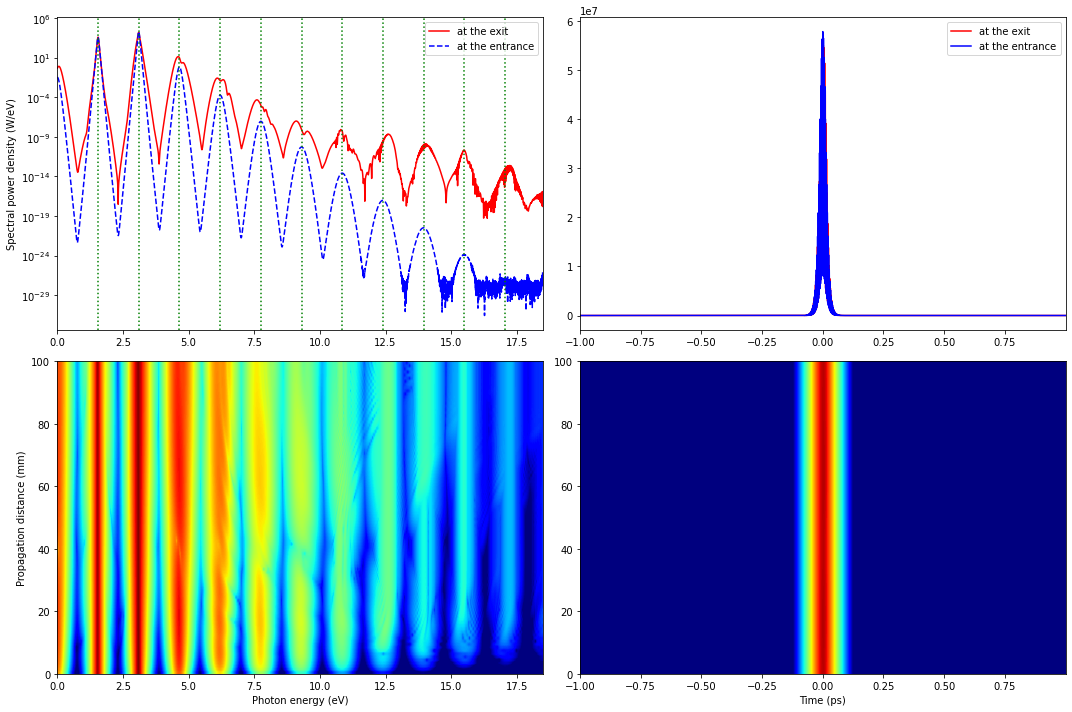

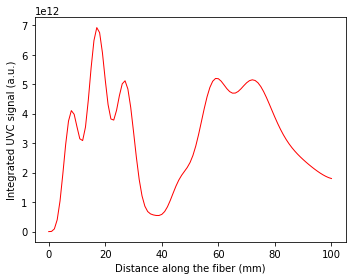

Pulse energy before Simple Fiber : 40715.04079052371 nJ
pulse energy in  14539610.975640126
copied as   14539610.975640126
Step: 0 Distance remaining: 0.1
Pulse energy after: 40462.96304711139 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 40463.970926120026 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 40465.54706160707 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 40467.47146020971 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 40469.604306763875 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 40471.93671405891 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 40474.53214723266 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 40477.410980117915 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 40480.5085289025 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 40483.66710598224 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 40486.64988246639 nJ
Step: 11 

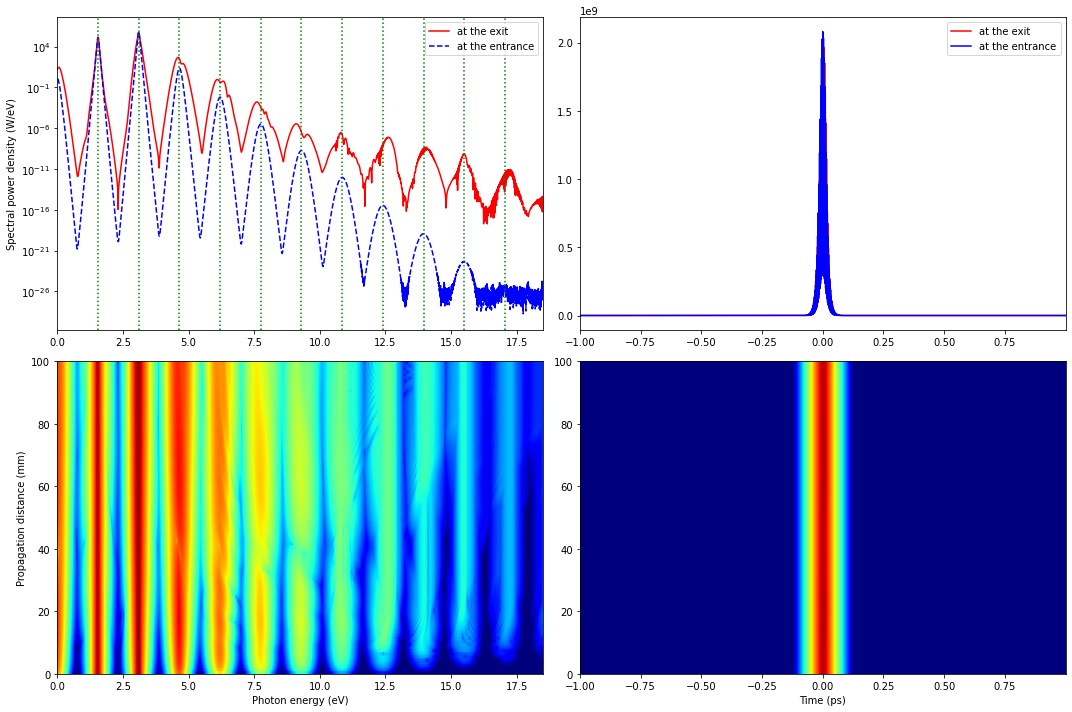

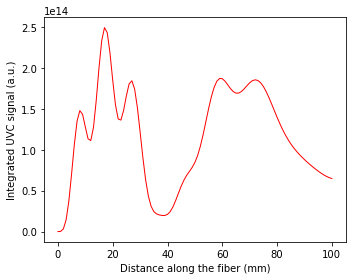

Pulse energy before Simple Fiber : 136847.77599037142 nJ
pulse energy in  26655953.45534023
copied as   26655953.45534023
Step: 0 Distance remaining: 0.1
Pulse energy after: 136000.5146861244 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 136003.90227945888 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 136009.19984595705 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 136015.6679634826 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 136022.83669773408 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 136030.67617780907 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 136039.39971708754 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 136049.07579428508 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 136059.48699992223 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 136070.10332844022 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 136080.1287716231 nJ
Step

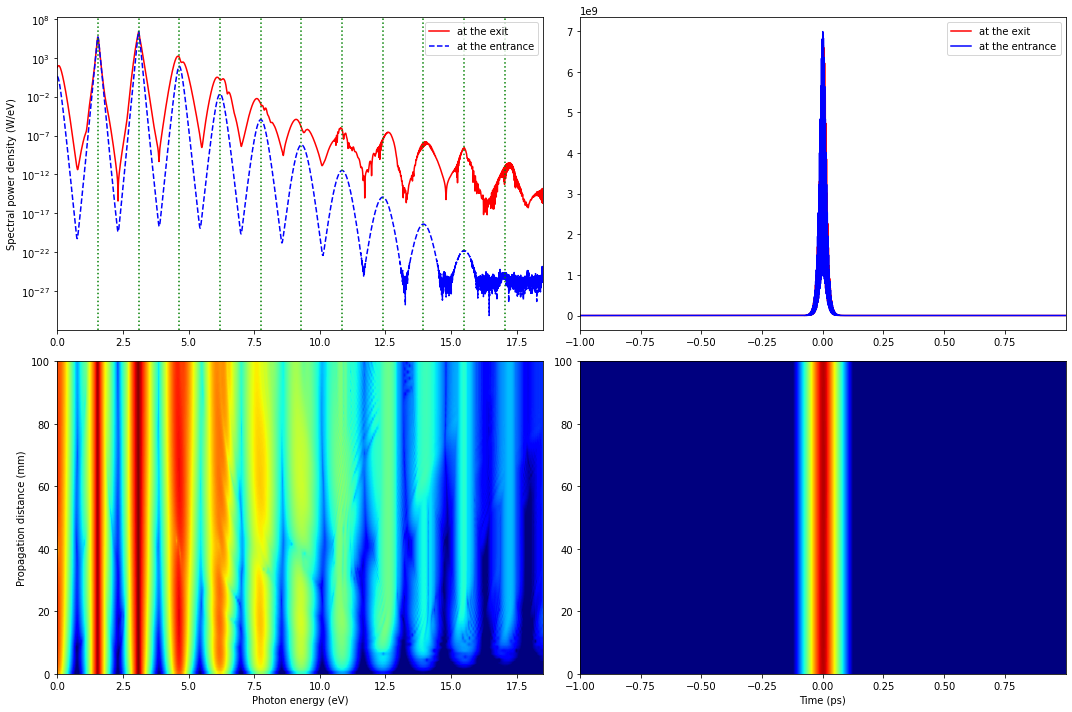

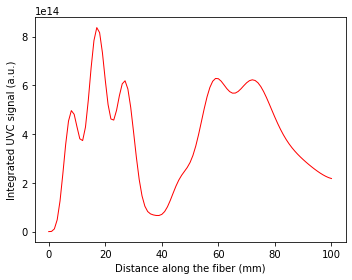

Pulse energy before Simple Fiber : 289529.1789548353 nJ
pulse energy in  38772295.93504034
copied as   38772295.93504034
Step: 0 Distance remaining: 0.1
Pulse energy after: 287736.6261127919 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 287743.7932524087 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 287755.00132698327 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 287768.6859392687 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 287783.8528480981 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 287800.43885552965 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 287818.89526920975 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 287839.3669697269 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 287861.3939833063 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 287883.8549758732 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 287905.06583087175 nJ
Step: 11 

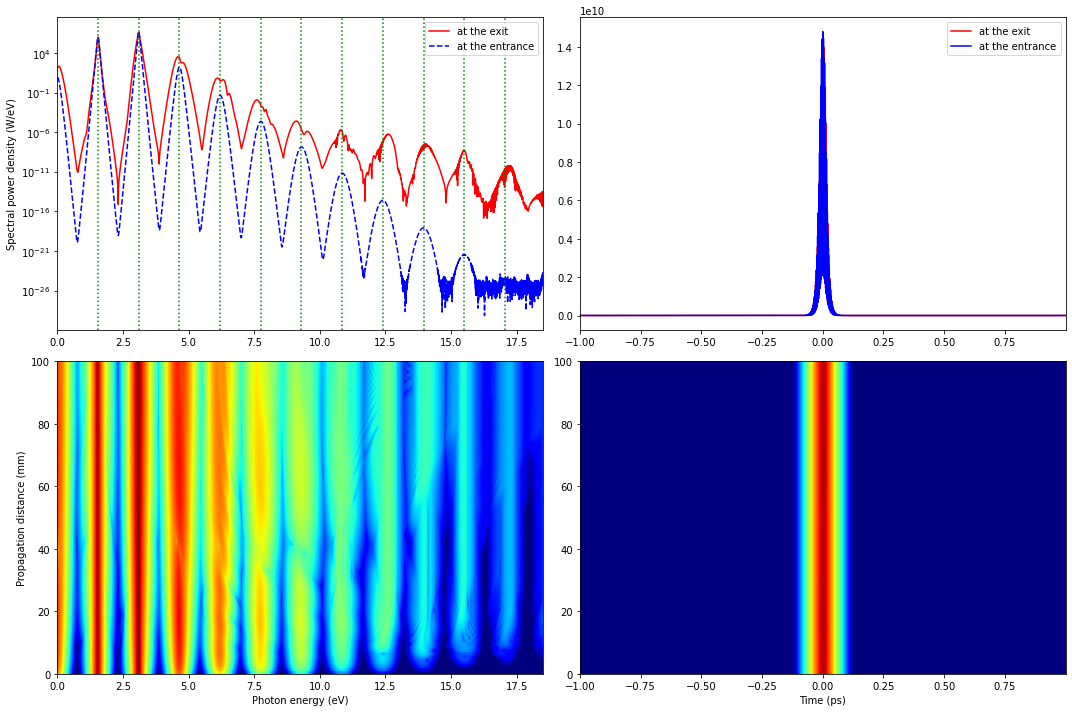

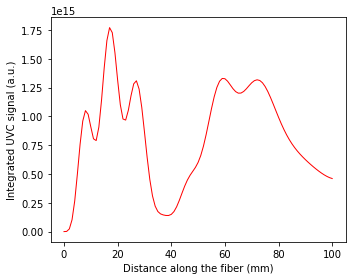

Pulse energy before Simple Fiber : 498759.24968391546 nJ
pulse energy in  50888638.41474044
copied as   50888638.41474044
Step: 0 Distance remaining: 0.1
Pulse energy after: 495671.29732711444 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 495683.64384497 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 495702.95150468644 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 495726.5253875688 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 495752.6527578572 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 495781.2247472214 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 495813.01880360016 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 495848.28450644424 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 495886.2294790554 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 495924.92204828205 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 495961.46106021304 nJ
Step: 11

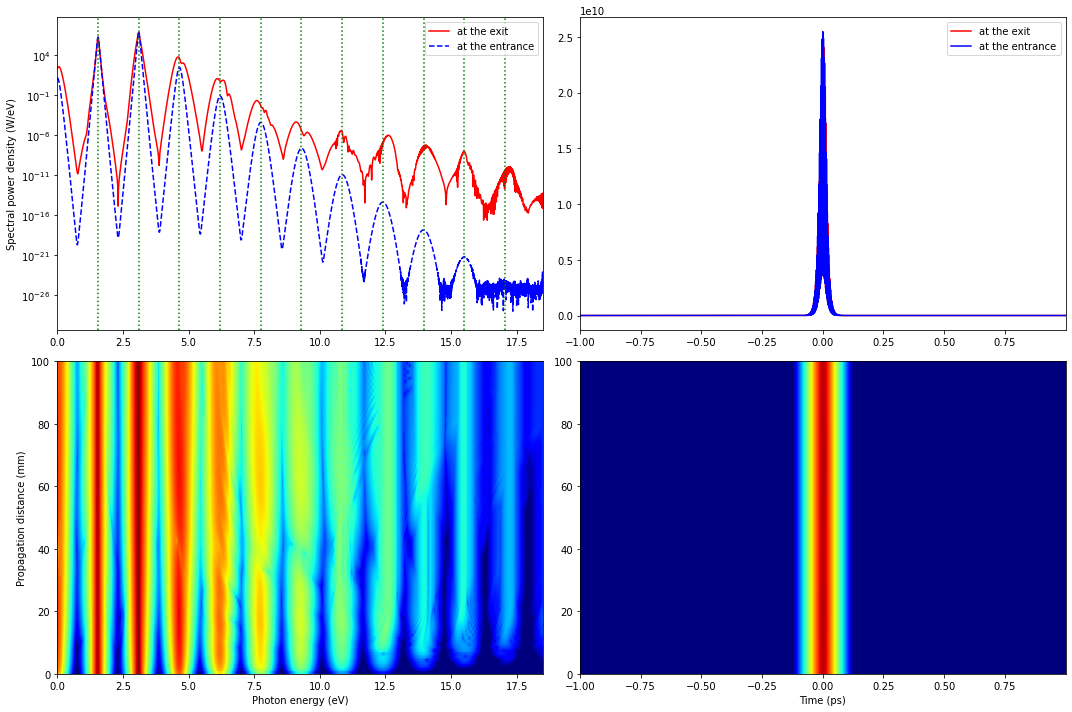

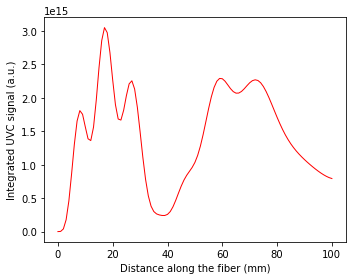

Pulse energy before Simple Fiber : 764537.9881776121 nJ
pulse energy in  63004980.894440554
copied as   63004980.894440554
Step: 0 Distance remaining: 0.1
Pulse energy after: 759804.5283290915 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 759823.4540571423 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 759853.0503790658 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 759889.1863083823 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 759929.2364270103 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 759973.0338528837 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 760021.770320258 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 760075.8284044362 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 760133.9934871688 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 760193.3045456661 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 760249.3144596465 nJ
Step: 11 Dis

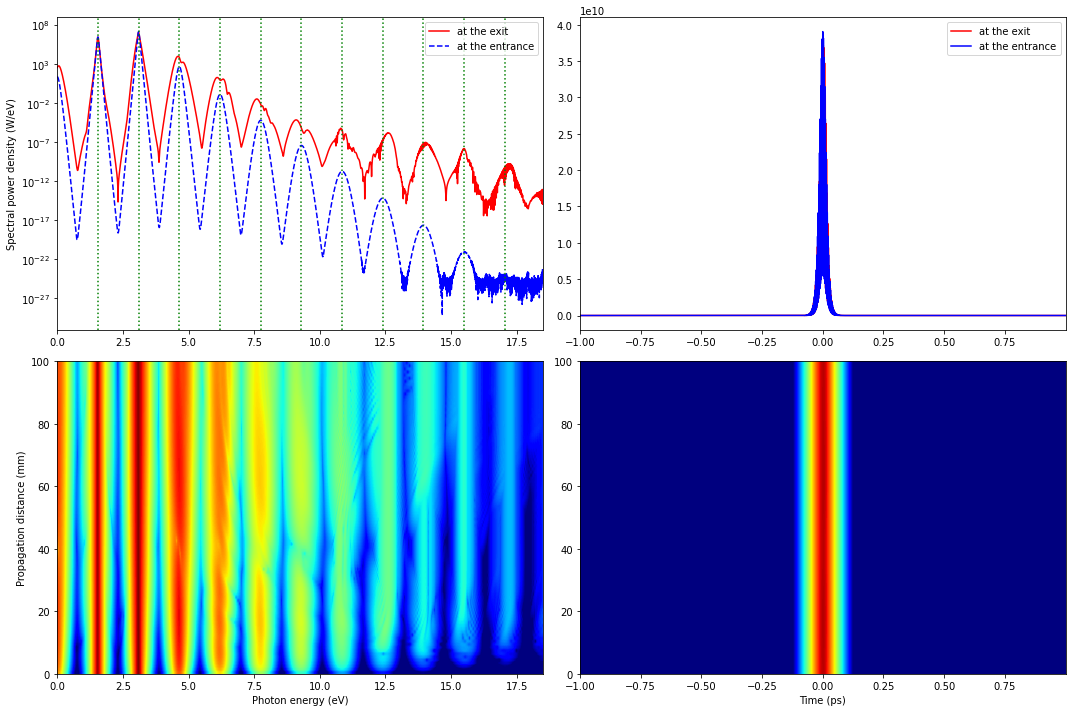

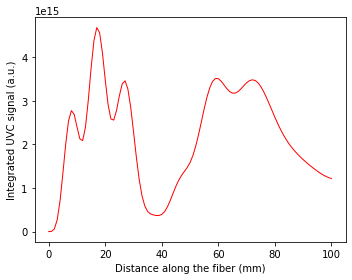

Pulse energy before Simple Fiber : 1130.9733552923253 nJ
pulse energy in  2423268.4959400212
copied as   2423268.4959400212
Step: 0 Distance remaining: 0.1
Pulse energy after: 1123.9651263876865 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 1123.9644596011024 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 1123.9639884328935 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 1123.963707417162 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 1123.9636108860425 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 1123.9636930080808 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 1123.9639478257754 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 1123.9643692914883 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 1123.964951301109 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 1123.9656877250798 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 1123.9665724365336 nJ
S

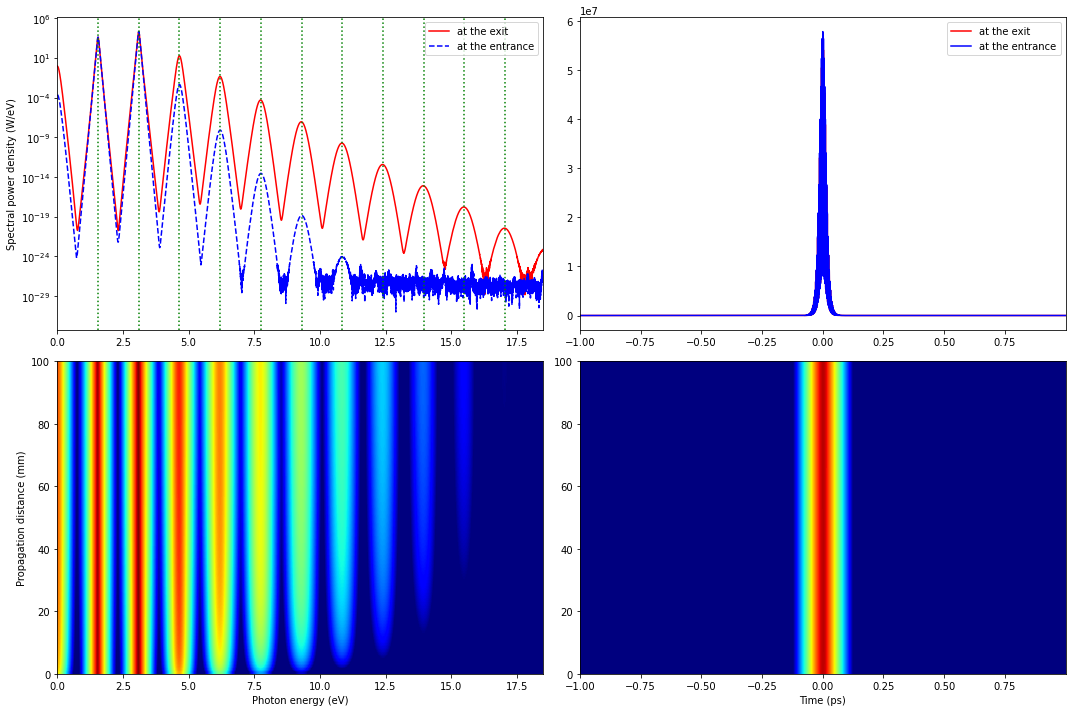

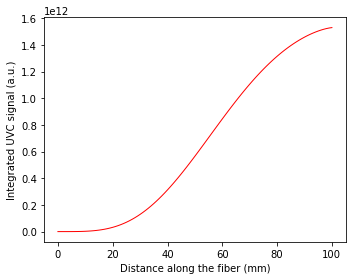

Pulse energy before Simple Fiber : 40715.04079052371 nJ
pulse energy in  14539610.975640126
copied as   14539610.975640126
Step: 0 Distance remaining: 0.1
Pulse energy after: 40462.7445499567 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 40462.720545639684 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 40462.703583584174 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 40462.69346701786 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 40462.689991897554 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 40462.69294829093 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 40462.70212172794 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 40462.71729449359 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 40462.73824683995 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 40462.76475810291 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 40462.79660771522 nJ
Step: 11 

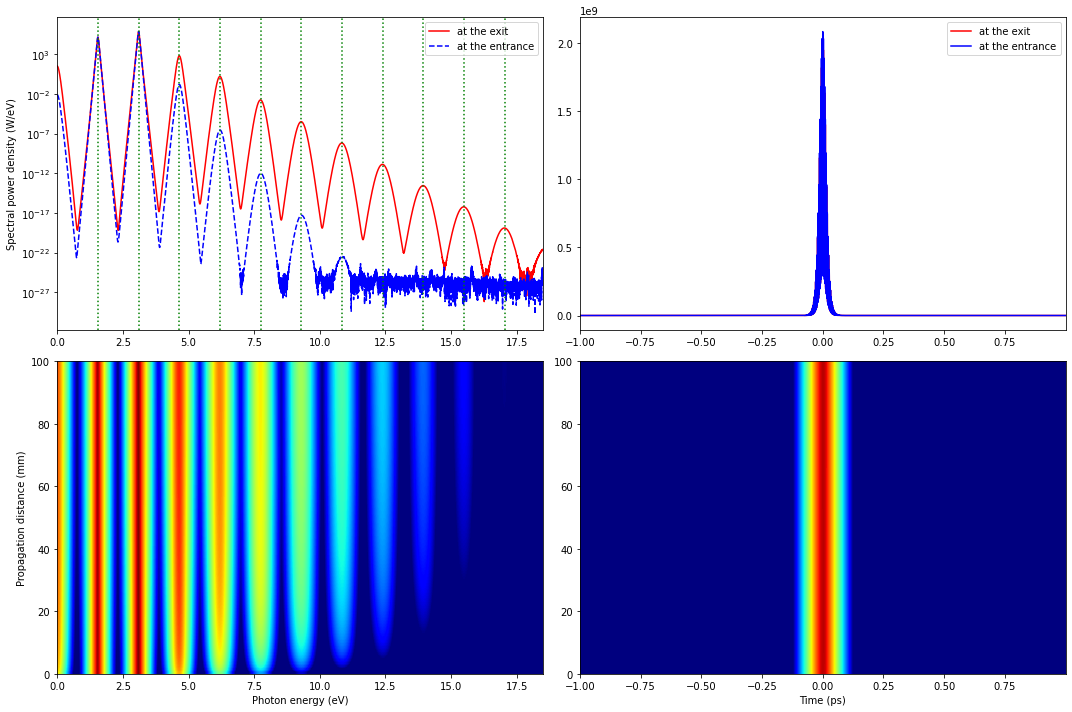

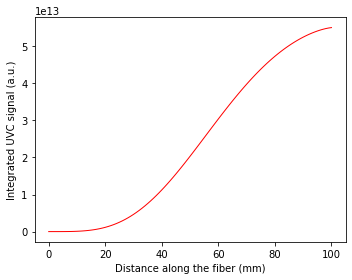

Pulse energy before Simple Fiber : 136847.77599037142 nJ
pulse energy in  26655953.45534023
copied as   26655953.45534023
Step: 0 Distance remaining: 0.1
Pulse energy after: 135999.7802929101 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 135999.69961173338 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 135999.64260038018 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 135999.6085974767 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 135999.59691721122 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 135999.6068539779 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 135999.63768691896 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 135999.68868427022 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 135999.75910743434 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 135999.84821473478 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 135999.9552648207 nJ
Step:

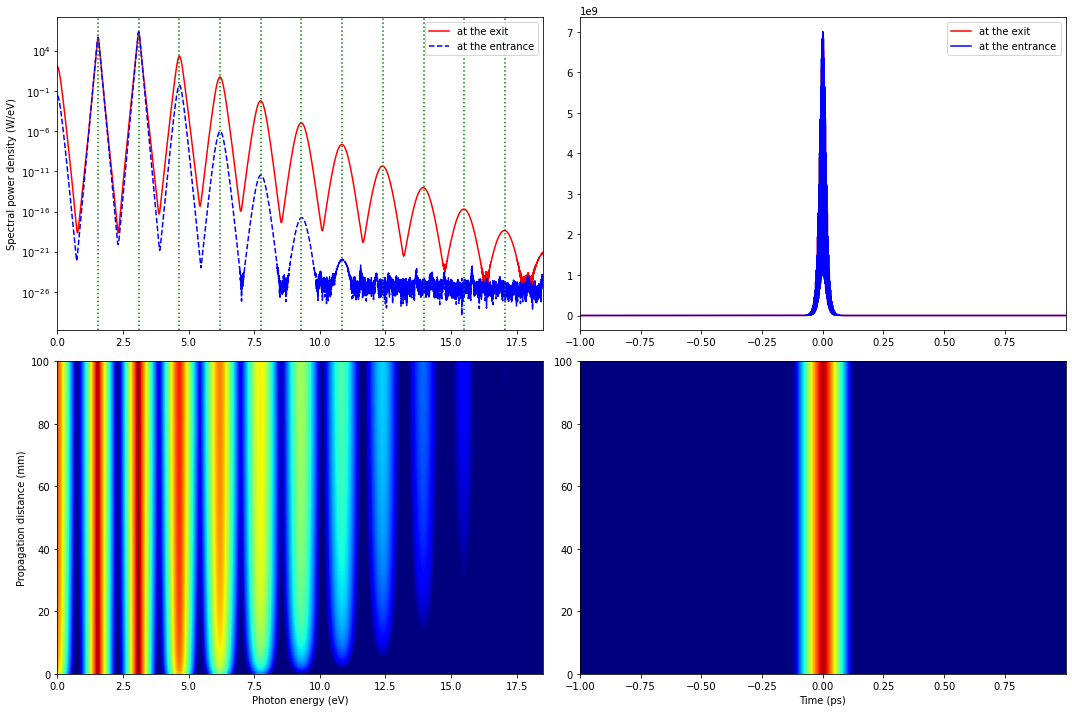

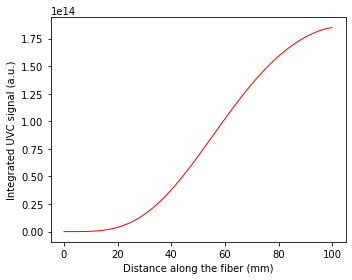

Pulse energy before Simple Fiber : 289529.1789548353 nJ
pulse energy in  38772295.93504034
copied as   38772295.93504034
Step: 0 Distance remaining: 0.1
Pulse energy after: 287735.07235524774 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 287734.9016578822 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 287734.78103882074 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 287734.70909879345 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 287734.6843868269 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 287734.7054100687 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 287734.7706433985 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 287734.878538621 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 287735.0275330839 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 287735.2160576204 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 287735.4425437526 nJ
Step: 11 Di

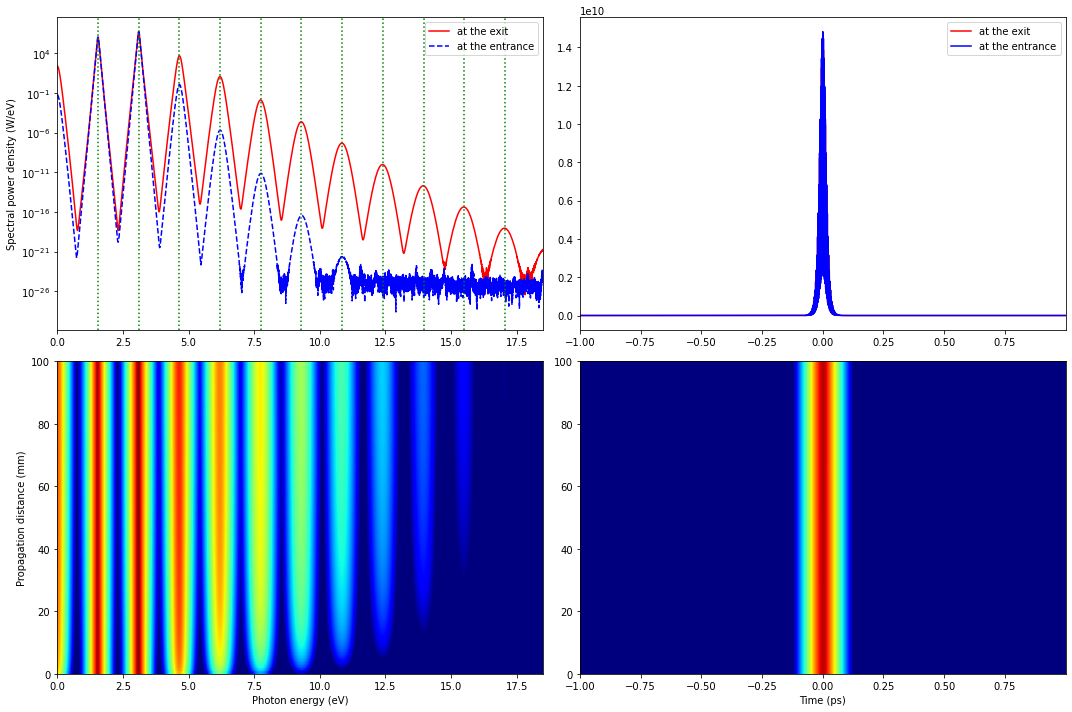

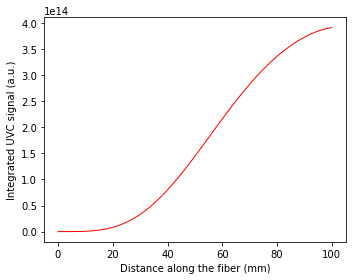

Pulse energy before Simple Fiber : 498759.24968391546 nJ
pulse energy in  50888638.41474044
copied as   50888638.41474044
Step: 0 Distance remaining: 0.1
Pulse energy after: 495668.6207369694 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 495668.32668408594 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 495668.1188989061 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 495667.9949709686 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 495667.95240074495 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 495667.9886165638 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 495668.1009911671 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 495668.2868575464 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 495668.5435237892 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 495668.8682867603 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 495669.2584445113 nJ
Step: 11 D

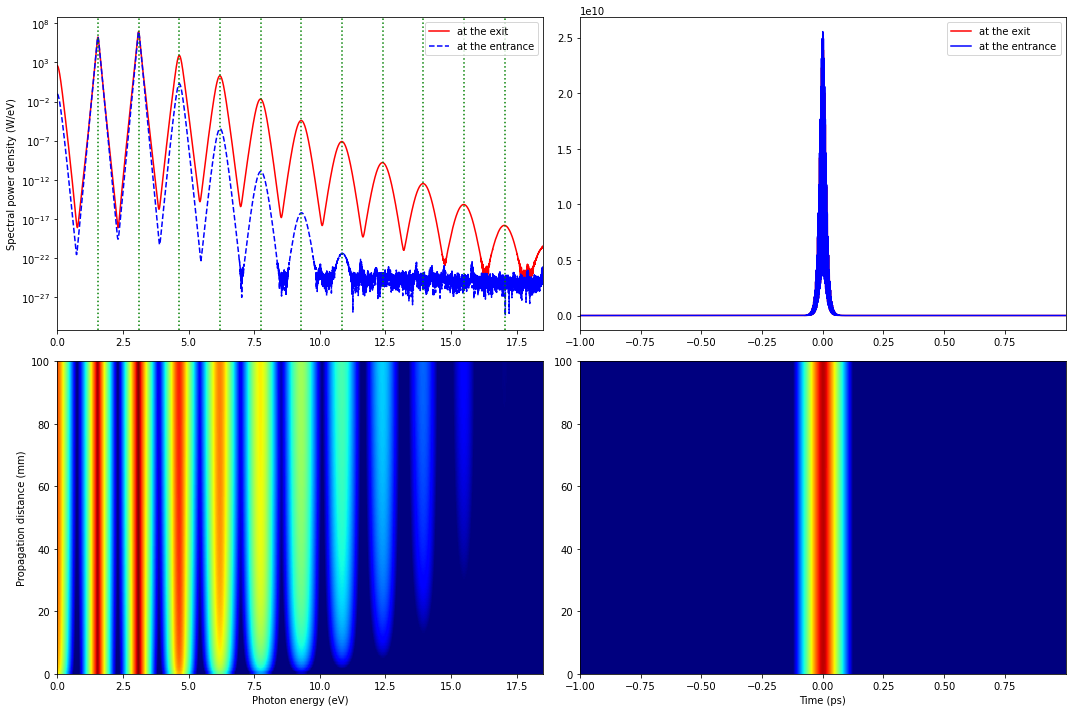

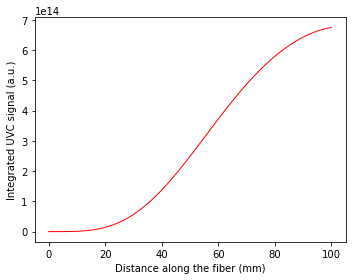

Pulse energy before Simple Fiber : 764537.9881776121 nJ
pulse energy in  63004980.894440554
copied as   63004980.894440554
Step: 0 Distance remaining: 0.1
Pulse energy after: 759800.4254380758 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 759799.9746903451 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 759799.6561806359 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 759799.4662140018 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 759799.4009589653 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 759799.4564734633 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 759799.628730225 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 759799.9136410465 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 759800.3070795505 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 759800.804902155 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 759801.4029670975 nJ
Step: 11 Dist

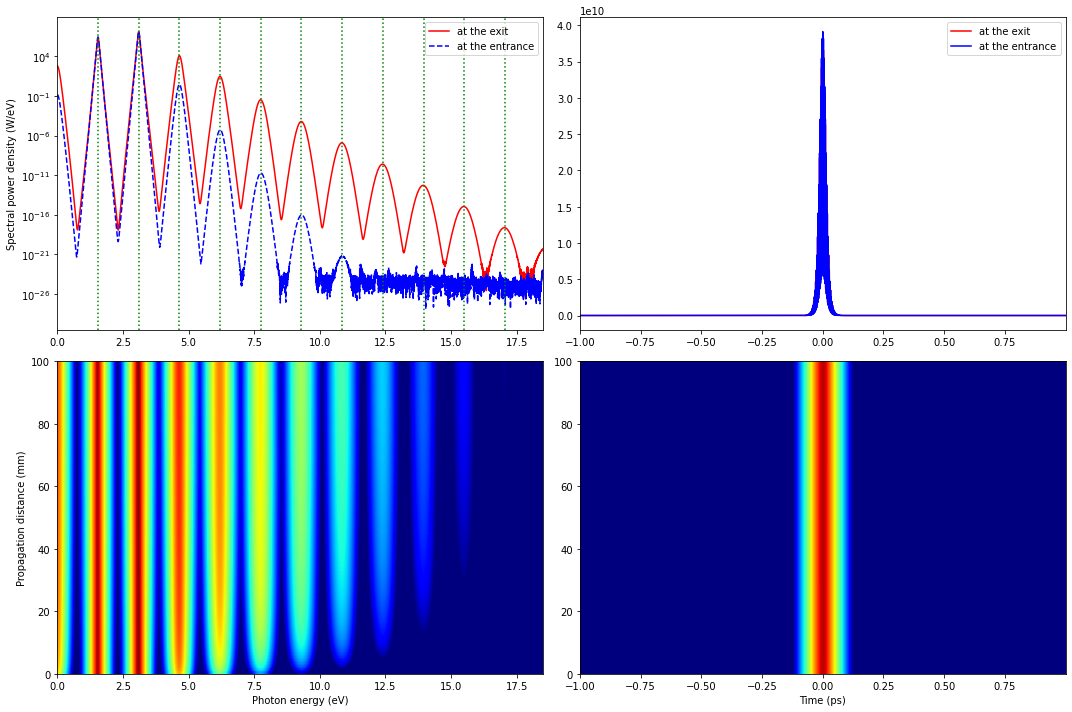

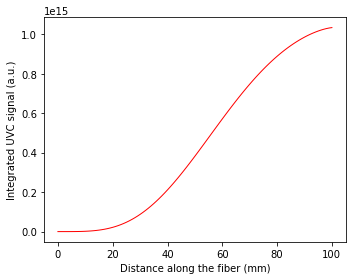

Pulse energy before Simple Fiber : 1130.9733552923253 nJ
pulse energy in  2423268.4959400212
copied as   2423268.4959400212
Step: 0 Distance remaining: 0.1
Pulse energy after: 1124.0156088131257 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 1124.1431886712735 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 1124.3009358288134 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 1124.4957285099022 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 1124.70786724582 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 1124.8673269081887 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 1124.9299784194857 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 1124.9074498076943 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 1124.8124832499614 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 1124.6315065618078 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 1124.3643539337177 nJ
S

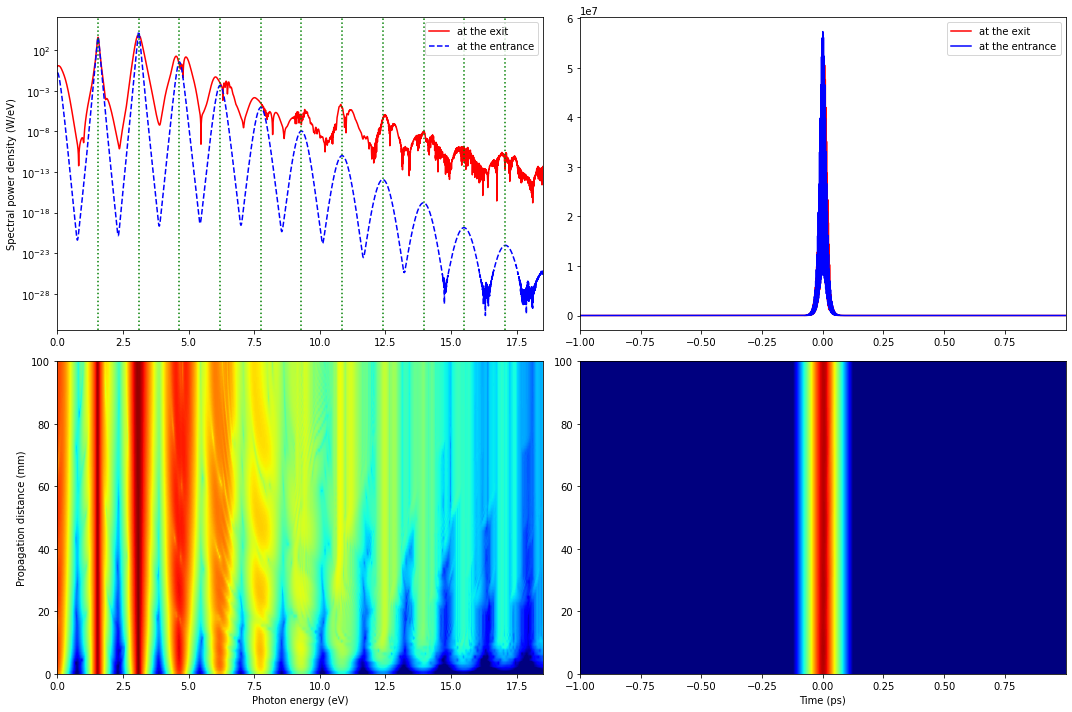

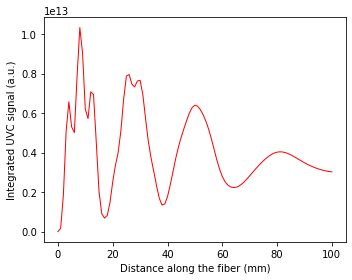

Pulse energy before Simple Fiber : 40715.04079052371 nJ
pulse energy in  14539610.975640126
copied as   14539610.975640126
Step: 0 Distance remaining: 0.1
Pulse energy after: 40464.56191727255 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 40469.15479216588 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 40474.83368983728 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 40481.84622635651 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 40489.483220849535 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 40495.223768694814 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 40497.479223101494 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 40496.668193077014 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 40493.249396998646 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 40486.734236225115 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 40477.11674161388 nJ
Step:

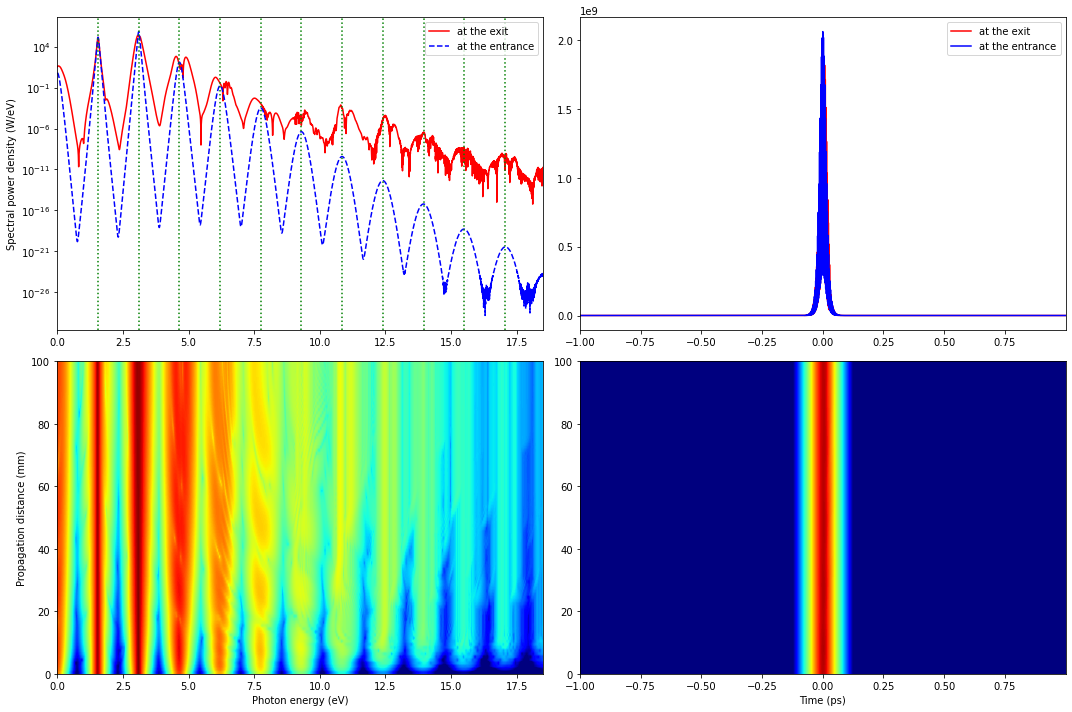

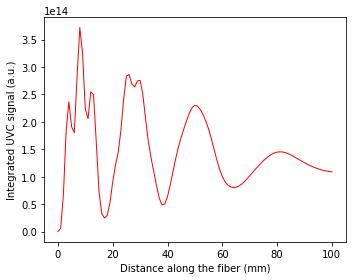

Pulse energy before Simple Fiber : 136847.77599037142 nJ
pulse energy in  26655953.45534023
copied as   26655953.45534023
Step: 0 Distance remaining: 0.1
Pulse energy after: 136005.88866638832 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 136021.32582922425 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 136040.41323528645 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 136063.98314969824 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 136089.65193674434 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 136108.946555891 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 136116.52738875785 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 136113.80142673114 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 136102.31047324548 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 136080.41229397885 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 136048.08682597993 nJ
Ste

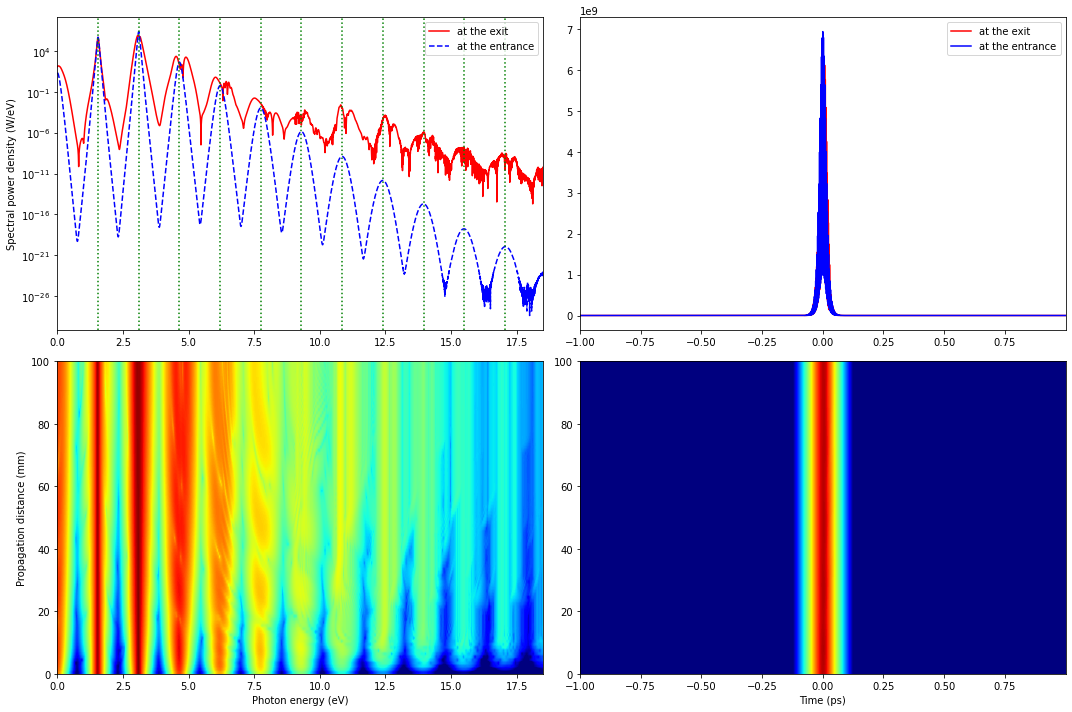

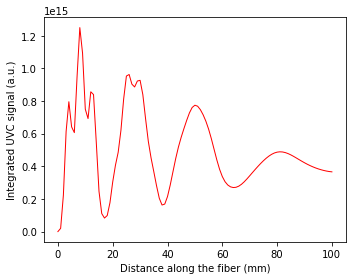

Pulse energy before Simple Fiber : 289529.1789548353 nJ
pulse energy in  38772295.93504034
copied as   38772295.93504034
Step: 0 Distance remaining: 0.1
Pulse energy after: 287747.9958561602 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 287780.656299846 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 287821.03957217623 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 287870.90649853495 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 287925.2140149299 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 287966.0356884963 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 287982.07447538833 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 287976.30715076975 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 287951.9957119901 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 287905.6656798228 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 287837.2746070317 nJ
Step: 11 D

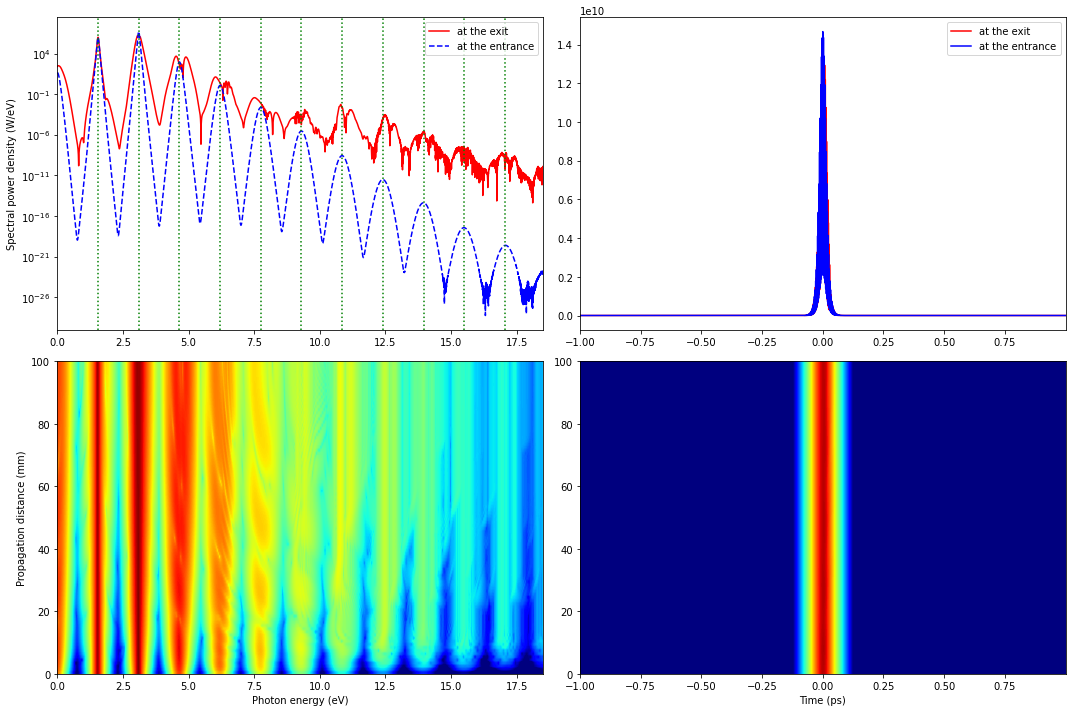

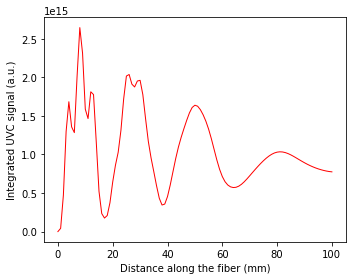

Pulse energy before Simple Fiber : 498759.24968391546 nJ
pulse energy in  50888638.41474044
copied as   50888638.41474044
Step: 0 Distance remaining: 0.1
Pulse energy after: 495690.8834865887 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 495747.1462040318 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 495816.71270050685 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 495902.616272867 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 495996.1694554069 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 496066.4911665115 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 496094.12048299325 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 496084.18536519364 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 496042.30511323333 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 495962.49439375754 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 495844.6800847699 nJ
Step: 11

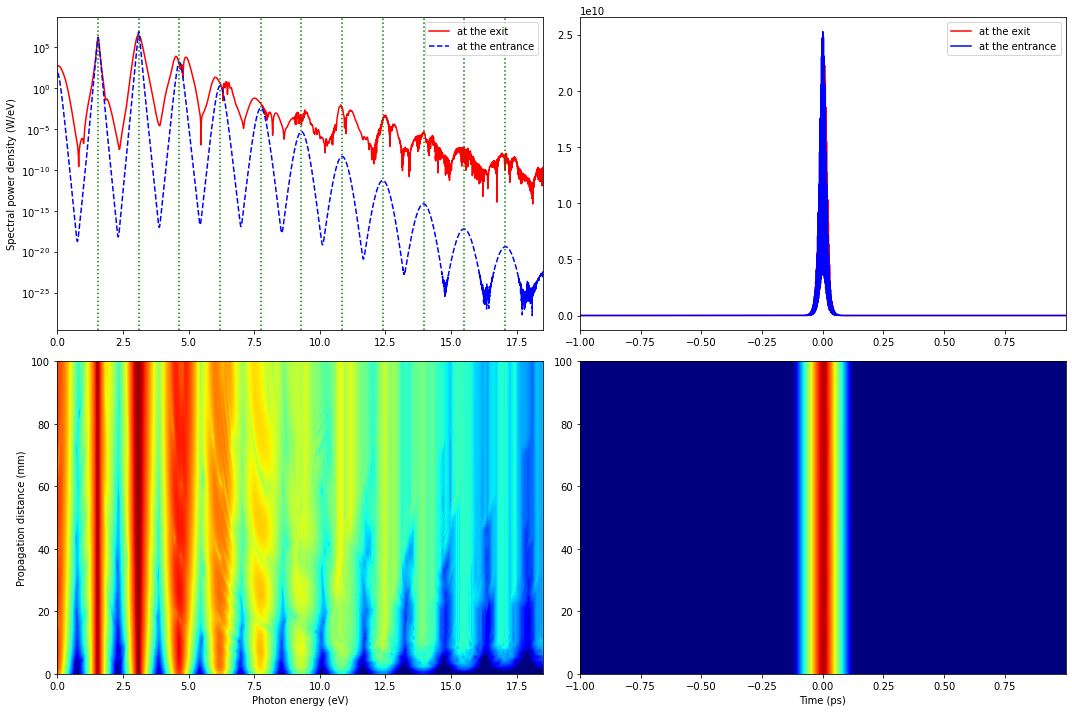

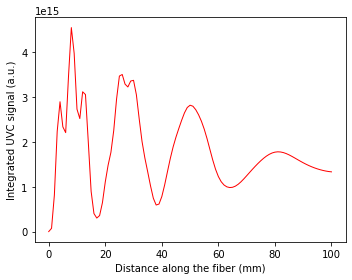

Pulse energy before Simple Fiber : 764537.9881776121 nJ
pulse energy in  63004980.894440554
copied as   63004980.894440554
Step: 0 Distance remaining: 0.1
Pulse energy after: 759834.5515576731 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 759920.7955417814 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 760027.4326202779 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 760159.1124726941 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 760302.5182581746 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 760410.3129899359 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 760452.6654115724 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 760437.4360700017 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 760373.2386769747 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 760250.8984357825 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 760070.3032591939 nJ
Step: 11 Di

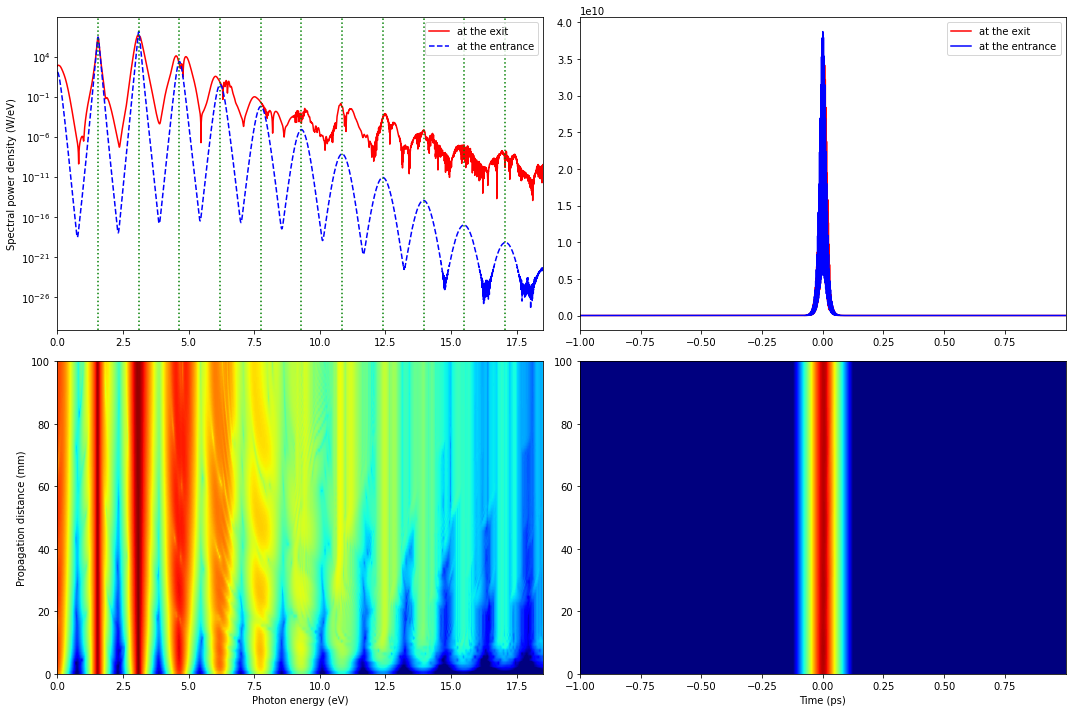

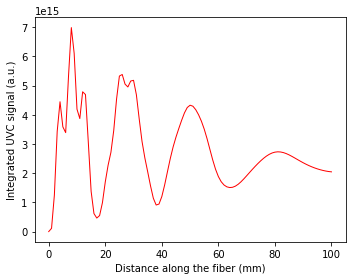

Pulse energy before Simple Fiber : 1130.9733552923253 nJ
pulse energy in  2423268.4959400212
copied as   2423268.4959400212
Step: 0 Distance remaining: 0.1
Pulse energy after: 1124.2767790892883 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 1124.844396147159 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 1125.092504272947 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 1124.7096933203834 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 1123.8231285826196 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 1123.0626939472209 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 1122.7645198451291 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 1122.985567626735 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 1123.3739537622182 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 1123.5726278768714 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 1123.3758351141628 nJ
St

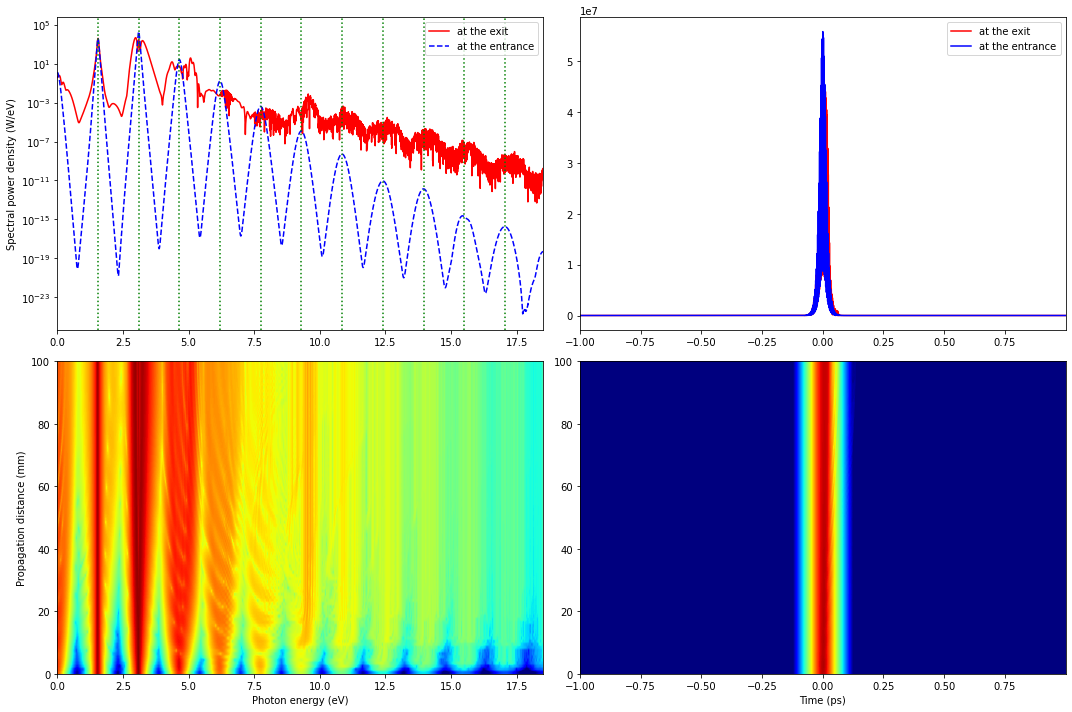

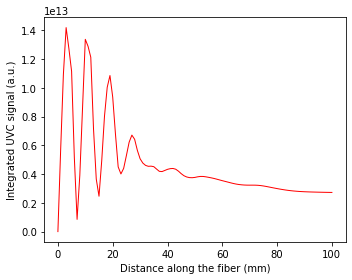

Pulse energy before Simple Fiber : 40715.04079052371 nJ
pulse energy in  14539610.975640126
copied as   14539610.975640126
Step: 0 Distance remaining: 0.1
Pulse energy after: 40473.96404721439 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 40494.39826129775 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 40503.33015382614 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 40489.548959533844 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 40457.63262897436 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 40430.25698209999 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 40419.52271442468 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 40427.48043456251 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 40441.46233543989 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 40448.6146035674 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 40441.53006410989 nJ
Step: 11 Di

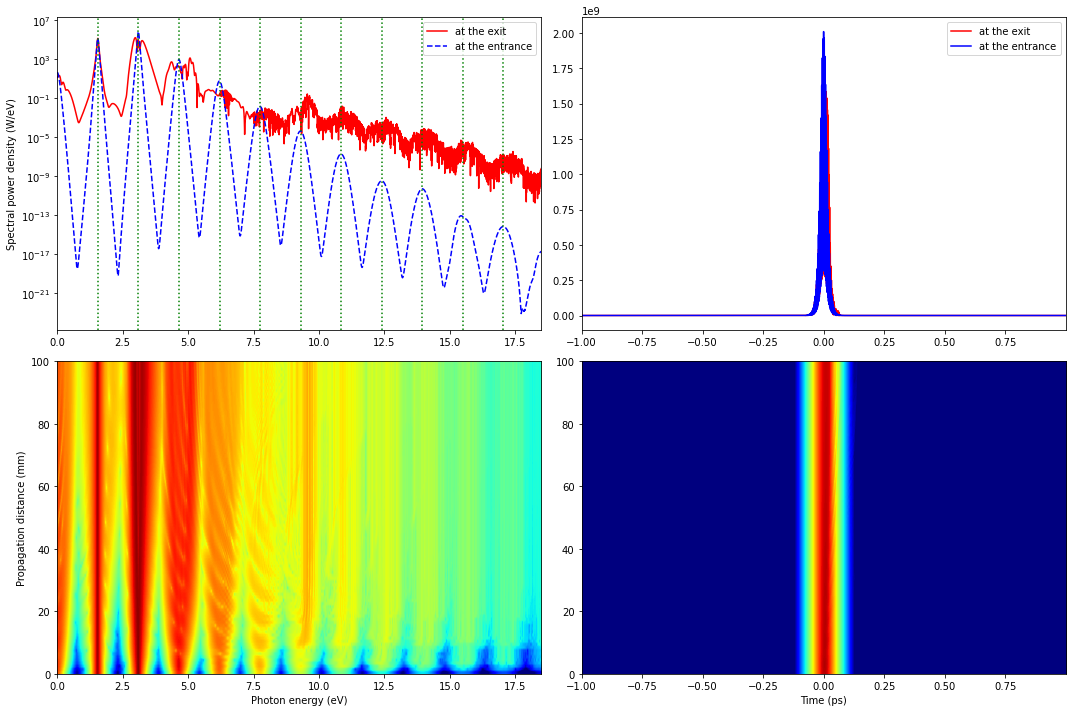

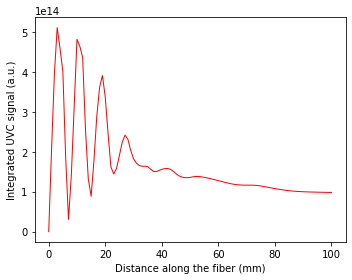

Pulse energy before Simple Fiber : 136847.77599037142 nJ
pulse energy in  26655953.45534023
copied as   26655953.45534023
Step: 0 Distance remaining: 0.1
Pulse energy after: 136037.49026980394 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 136106.1719338063 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 136136.19301702664 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 136089.87289176643 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 135982.5985584971 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 135890.5859676138 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 135854.50690126076 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 135881.25368283506 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 135928.24840522843 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 135952.28797310148 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 135928.4760488137 nJ
Step:

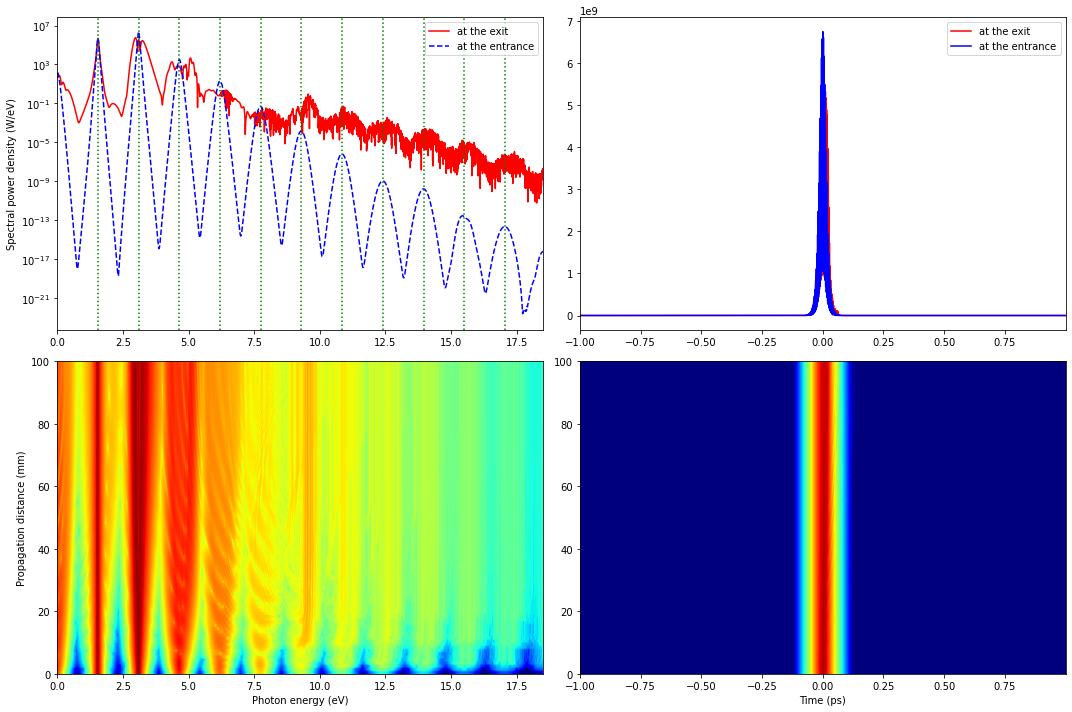

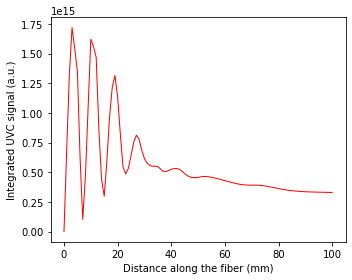

Pulse energy before Simple Fiber : 289529.1789548353 nJ
pulse energy in  38772295.93504034
copied as   38772295.93504034
Step: 0 Distance remaining: 0.1
Pulse energy after: 287814.8554468578 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 287960.1654136727 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 288023.68109387445 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 287925.68149001815 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 287698.7209171506 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 287504.04965048854 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 287427.71708035306 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 287484.30531244416 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 287583.73216312786 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 287634.59273647907 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 287584.2137892257 nJ
Step: 

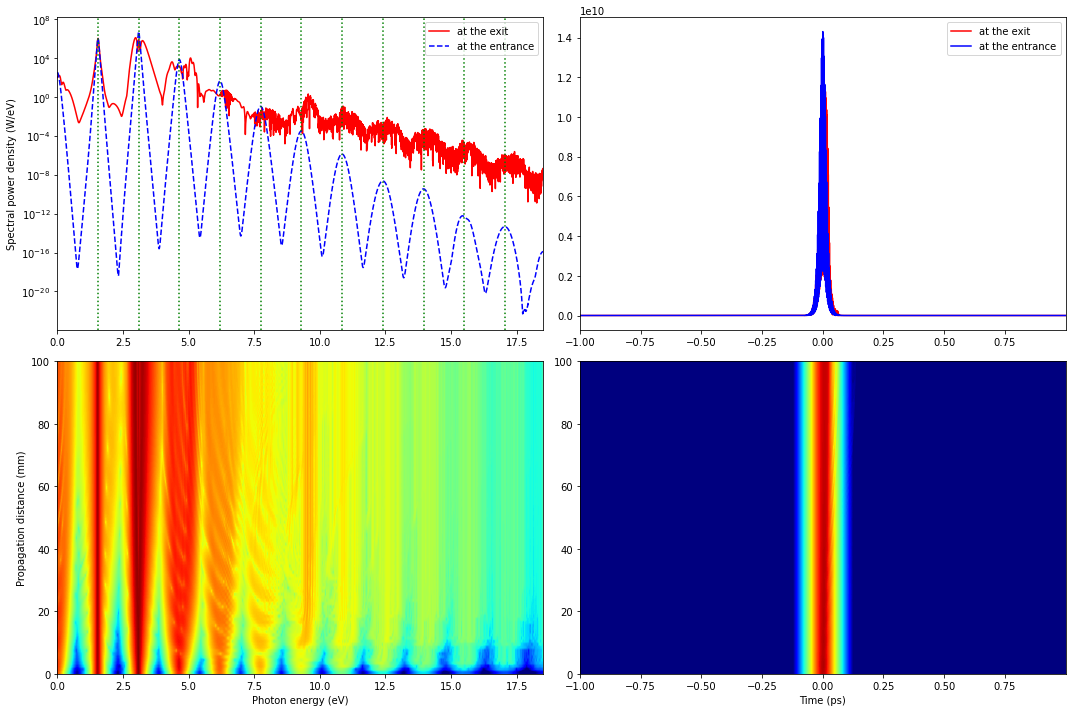

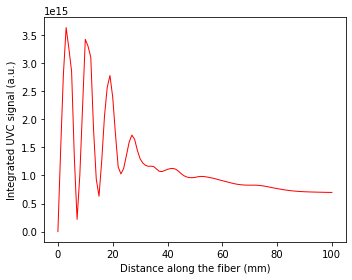

Pulse energy before Simple Fiber : 498759.24968391546 nJ
pulse energy in  50888638.41474044
copied as   50888638.41474044
Step: 0 Distance remaining: 0.1
Pulse energy after: 495806.05957837607 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 496056.37870089686 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 496165.7943843695 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 495996.97475428885 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 495605.99970493536 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 495270.64803072426 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 495139.1532517019 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 495236.6353233902 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 495407.913609138 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 495495.5288937002 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 495408.7432853456 nJ
Step: 11

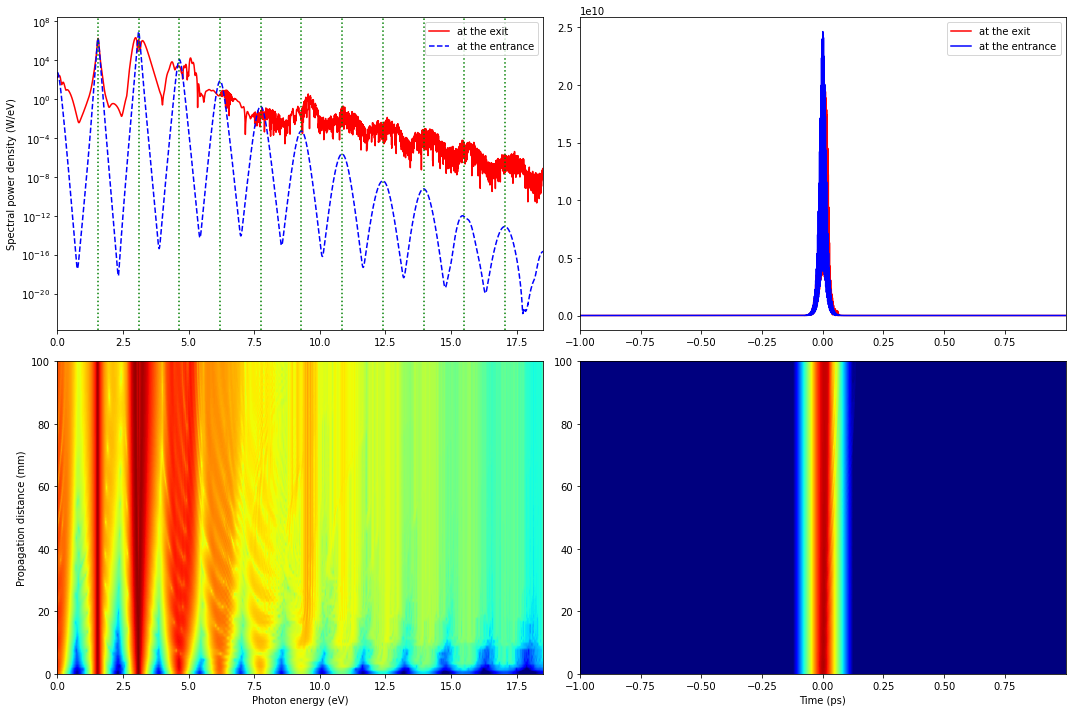

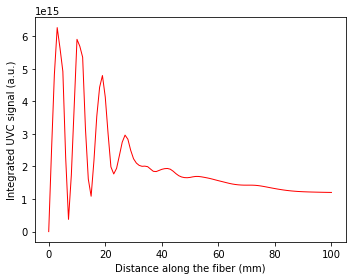

Pulse energy before Simple Fiber : 764537.9881776121 nJ
pulse energy in  63004980.894440554
copied as   63004980.894440554
Step: 0 Distance remaining: 0.1
Pulse energy after: 760011.1026643594 nJ
Step: 1 Distance remaining: 0.099
Pulse energy after: 760394.81179548 nJ
Step: 2 Distance remaining: 0.098
Pulse energy after: 760562.5328885128 nJ
Step: 3 Distance remaining: 0.097
Pulse energy after: 760303.7526845796 nJ
Step: 4 Distance remaining: 0.096
Pulse energy after: 759704.4349218516 nJ
Step: 5 Distance remaining: 0.095
Pulse energy after: 759190.3811083218 nJ
Step: 6 Distance remaining: 0.094
Pulse energy after: 758988.815415308 nJ
Step: 7 Distance remaining: 0.093
Pulse energy after: 759138.2437156737 nJ
Step: 8 Distance remaining: 0.09200000000000001
Pulse energy after: 759400.7927432602 nJ
Step: 9 Distance remaining: 0.09100000000000001
Pulse energy after: 759535.0964447658 nJ
Step: 10 Distance remaining: 0.09000000000000001
Pulse energy after: 759402.0645371745 nJ
Step: 11 Dista

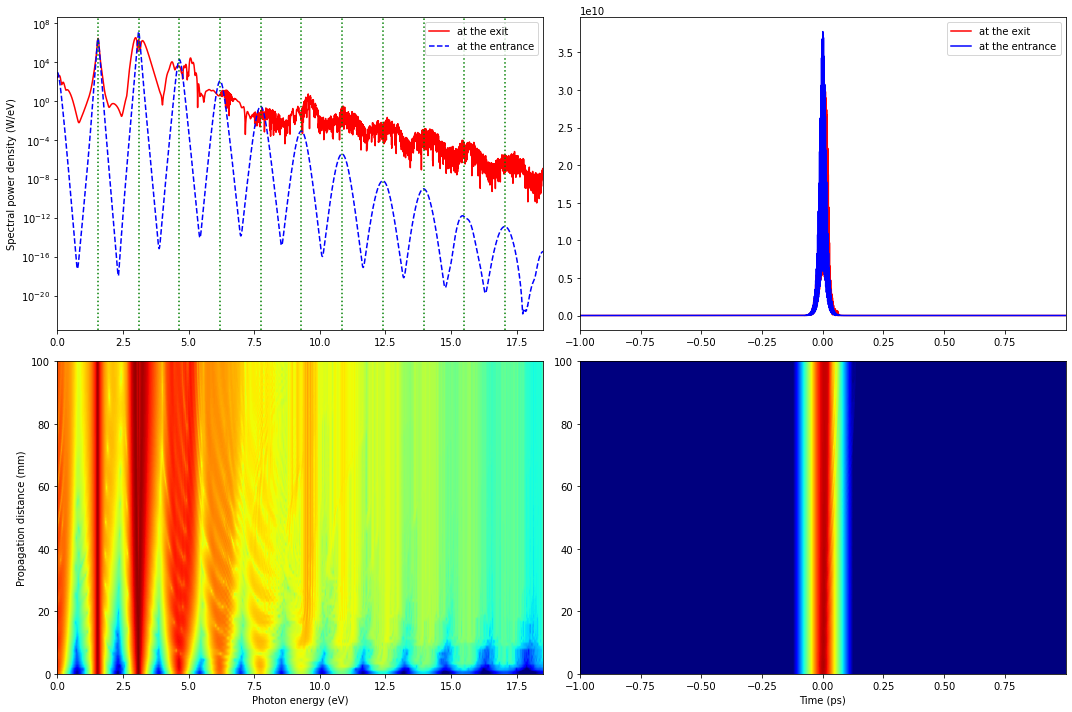

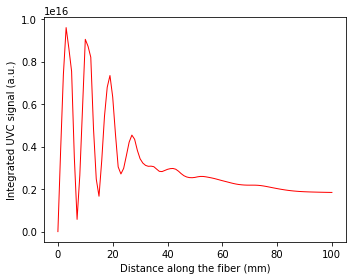

In [61]:
gases = ["Argon", "Neon", "Krypton", "Xenon"]

for gas in gases:
    n2_at_one_bar, betas_at_one_bar = loadGasParameters(gas)
    for i in range(len(fiber_rad)):
        gasbuilder = GasPropertyBuilder(fiber_length=Length*1e-3, 
                                        fiber_radius=fiber_rad[i], 
                                        fiber_wavelength=fibWL, 
                                        pulse_wavelength=pulseWL, 
                                        betas_at_one_bar=betas_at_one_bar, 
                                        constant_pressure=None, 
                                        pressure_boundary=[1000,0], 
                                        n2_at_one_bar=n2_at_one_bar, 
                                        differential_pumping=True)

        # create the fiber
        fiber = pynlo.media.fibers.fiber.FiberInstance()
        fiber.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=gasbuilder.dispersionFunction(0),
                                  gamma_W_m=gasbuilder.gammaDistribution(0), gain=-alpha)

        # provide a function for gamma (the effective nonlinearity, in units of 1/(W m)) that varies
        # as a function of the length along the fiber
        fiber.set_gamma_function(gasbuilder.gammaDistribution)

        # provide a function for the fiber dispersion that varies as a function of the length along
        # the fiber, GVD in units of ps^n/m, NOT ps^n/km
        fiber.set_dispersion_function(gasbuilder.dispersionFunction, dispersion_format='GVD')


        # create the fundamental pulse
        pulse_FD = pynlo.light.DerivedPulses.SechPulse(
            1, FWHM/1.76, pulseWL, time_window_ps=Window,
            GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1e-3, power_is_avg=True
        )
        pulse_FD.set_epp(EPP_FD[i])

        # create the second harmonic pulse
        pulse_SH = pulse_FD.interpolate_to_new_center_wl(pulseWL/2)
        pulse_SH.set_epp(EPP_SH[i])

        # create the combined pulse
        pulse = pynlo.light.PulseBase.Pulse()
        pulse.set_NPTS(Points)
        pulse.set_time_window_ps(Window)
        pulse.set_center_wavelength_nm(fibWL)
        pulse.set_AW(pulse_FD.AW + pulse_SH.AW)

        # propagation
        evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                         disable_Raman=np.logical_not(Raman),
                         disable_self_steepening=np.logical_not(Steep))

        y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber, n_steps=Steps, reload_fiber_each_step=True)

        print("The following results are for: ")
        print(f"\tGas: {gas}")
        print(f"\tFiber radius: {fiber_rad[i]*1e6:.4} microns")
        print(f"\tInput pulse energy: {total_EPP[i]*1e3:.4} mJ")

        # set up plots for the results
        fig = plt.figure(figsize=(15,10))
        ax0 = plt.subplot2grid((2,2), (0, 0), rowspan=1)
        ax1 = plt.subplot2grid((2,2), (0, 1), rowspan=1)
        ax2 = plt.subplot2grid((2,2), (1, 0), rowspan=1, sharex=ax0)
        ax3 = plt.subplot2grid((2,2), (1, 1), rowspan=1, sharex=ax1)

        W_eV = photonEnergyGrid(pulse_SH)
        y_mm = y * 1e3  # convert distance to mm
        zW = dB(np.transpose(AW)[:, (W_eV > 0)])
        zT = dB(np.transpose(AT))
        intensity_freq = np.abs(np.transpose(AW)[:, (W_eV > 0)])**2
        intensity_time = np.abs(np.transpose(AT))**2
        
        ax0.plot(W_eV[W_eV > 0], intensity_freq[-1], color='r', linestyle='solid', label='at the exit')
        ax0.plot(W_eV[W_eV > 0], intensity_freq[0], color='b', linestyle='dashed', label='at the entrance')

        ax1.plot(pulse.T_ps, intensity_time[-1], color='r', label='at the exit')
        ax1.plot(pulse.T_ps, intensity_time[0], color='b', label='at the entrance')
        
        extent = (np.min(W_eV[W_eV > 0]), np.max(W_eV[W_eV > 0]), 0, Length)
        ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 250.0,
                         vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

        extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y_mm), Length)
        ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
                   vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')
        
        ax0.legend()
        ax0.set_yscale('log')
        ax0.set_ylabel('Spectral power density (W/eV)')
        
        ax1.legend()
        ax2.set_xlabel('Photon energy (eV)')
        ax3.set_xlabel('Time (ps)')
        
        ax2.set_xlim(0,18.5)
        ax2.set_ylabel('Propagation distance (mm)')

        HHGs = [1.55 * (i + 1) for i in range(11)]
        for HHG in HHGs:
            ax0.axvline(x=HHG, color='g', linestyle=':')
            
        plt.tight_layout()
        plt.show()
        
        # UVC region       
        wl_grid_nm = pulse_out.wl_nm
        UVC_filter = (wl_grid_nm>200) & (wl_grid_nm<300)

        spectral_intensity = np.abs(np.transpose(AW)[:, UVC_filter])**2
        spectral_intensity_0 = np.abs(np.transpose(pulse.AW)[UVC_filter])**2

        total_spectral_signal = pulse_out.dF_mks * np.trapz(spectral_intensity, axis=-1) 
        total_spectral_signal_0 = pulse.dF_mks * np.trapz(spectral_intensity_0)
        
        distance_along_fiber = np.arange(0,100+100/Steps,100/Steps)
        spectral_signal_along_fiber = np.insert(total_spectral_signal, 0, total_spectral_signal_0)

        fig, ax = plt.subplots(figsize=(5,4))
        ax.plot(distance_along_fiber, spectral_signal_along_fiber, color='red', linestyle='solid', linewidth=1)
        ax.set_xlabel('Distance along the fiber (mm)')
        ax.set_ylabel('Integrated UVC signal (a.u.)')
        
        plt.tight_layout()
        plt.show()
